# TensroFlow Quantum でQCL

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 学習データの作成

[QuantumNativeDojo](https://dojo.qulacs.org/ja/latest/notebooks/5.2_Quantum_Circuit_Learning.html)を参考にした

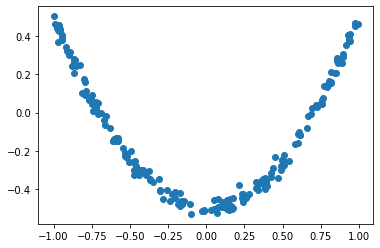

In [4]:
## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 200

## 学習したい1変数関数
#func_to_learn = lambda x: np.cos(x*np.pi)
func_to_learn = lambda x: x**2-0.5

random_seed = 1
np.random.seed(random_seed)

#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.025
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [5]:
def divide_train_test(data,label, test_ratio=0.3):
    shuffled = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_index = shuffled[:test_size]
    train_index = shuffled[test_size:]
    return data[train_index],label[train_index],data[test_index],label[test_index]

In [6]:
x_train,y_train,x_test,y_test=divide_train_test(x_train,y_train,test_ratio=0.25)

## 入力状態の作成

In [7]:
def convert_to_circuit(x):
    """Encode truncated classical image into quantum datapoint."""
    y = np.arcsin(x)
    z = np.arccos(x**2)
    qubits = cirq.GridQubit.rect(5, 1)
    circuit = cirq.Circuit()
    for i in range(5):
        circuit.append(cirq.ry(y).on(qubits[i]))
        circuit.append(cirq.rz(z).on(qubits[i]))
    return circuit


In [8]:
x_train_circ = [convert_to_circuit(x) for x in x_train]
x_test_circ = [convert_to_circuit(x) for x in x_test]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


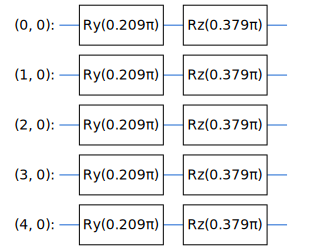

In [9]:
SVGCircuit(x_train_circ[0])

In [10]:
x_train[0],np.arcsin(x_train[0])/np.pi

(0.6095091274866908, 0.2086334341333908)

In [11]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## パラメトリック量子回路（ニューラルネット）の作成

In [12]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
            
    def add_layer_single(self,circuit,gate,prefix):
        symbol = sympy.Symbol(prefix + '-' + str(0))
        circuit.append(gate(symbol).on(self.readout))
    
    def add_entangler(self,circuit,len_qubit):
        circuit.append(cirq.CZ(self.readout,self.data_qubits[0]))
        for i in range(len_qubit-1):
            circuit.append(cirq.CZ(self.data_qubits[i],self.data_qubits[(i+1)%len_qubit]))
        circuit.append(cirq.CZ(self.readout,self.data_qubits[-1]))
            

In [13]:
def create_quantum_model(c_depth=3):
    data_qubits = cirq.GridQubit.rect(5,1)
    readout = cirq.GridQubit(-1,-1)
    circuit = cirq.Circuit()
    
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout = readout
    )
    
    for i in range(3):
        builder.add_entangler(circuit,5)
        builder.add_layer(circuit, gate = cirq.XX, prefix='xx'+str(i))
        builder.add_layer(circuit, gate = cirq.ZZ, prefix='zz'+str(i))
        builder.add_layer(circuit, gate = cirq.XX, prefix='xx1'+str(i))
        builder.add_layer_single(circuit, gate = cirq.rz, prefix='z1'+str(i))
        builder.add_layer_single(circuit, gate = cirq.rx, prefix='x1'+str(i))
        builder.add_layer_single(circuit, gate = cirq.rz, prefix='z2'+str(i))
        
    
    return circuit, cirq.Z(readout)

In [14]:
model_circuit, model_readout = create_quantum_model()

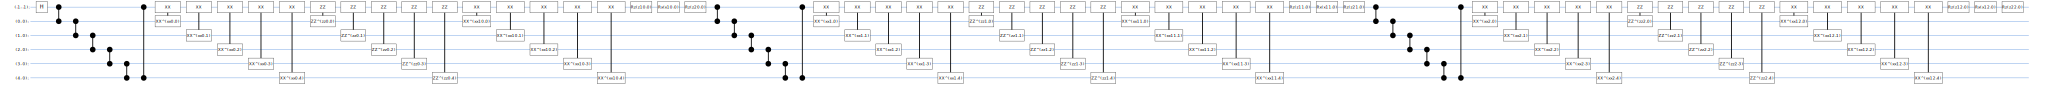

In [15]:
SVGCircuit(model_circuit)

In [16]:
model_readout

cirq.Z.on(cirq.GridQubit(-1, -1))

In [17]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [18]:
model.compile(
    loss=tf.keras.losses.mse,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['mae'])

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 54        
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
EPOCHS = 100
BATCH_SIZE = 50

In [21]:
qnn_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=25,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc,y_test)
)

Train on 150 samples, validate on 50 samples
Epoch 1/100
150/150 [==============================] - 5s 34ms/sample - loss: 0.2067 - mae: 0.4036 - val_loss: 0.1548 - val_mae: 0.3429
Epoch 2/100
150/150 [==============================] - 3s 21ms/sample - loss: 0.1762 - mae: 0.3751 - val_loss: 0.1315 - val_mae: 0.3190
Epoch 3/100
150/150 [==============================] - 3s 21ms/sample - loss: 0.1491 - mae: 0.3465 - val_loss: 0.1110 - val_mae: 0.2953
Epoch 4/100
150/150 [==============================] - 3s 22ms/sample - loss: 0.1253 - mae: 0.3201 - val_loss: 0.0936 - val_mae: 0.2726
Epoch 5/100
150/150 [==============================] - 3s 22ms/sample - loss: 0.1044 - mae: 0.2928 - val_loss: 0.0795 - val_mae: 0.2511
Epoch 6/100
150/150 [==============================] - 3s 22ms/sample - loss: 0.0878 - mae: 0.2680 - val_loss: 0.0680 - val_mae: 0.2324
Epoch 7/100
150/150 [==============================] - 4s 25ms/sample - loss: 0.0738 - mae: 0.2449 - val_loss: 0.0589 - val_mae: 0.2168
Epo

150/150 [==============================] - 4s 24ms/sample - loss: 0.0014 - mae: 0.0295 - val_loss: 0.0020 - val_mae: 0.0322
Epoch 61/100
150/150 [==============================] - 3s 23ms/sample - loss: 0.0014 - mae: 0.0292 - val_loss: 0.0020 - val_mae: 0.0319
Epoch 62/100
150/150 [==============================] - 3s 23ms/sample - loss: 0.0014 - mae: 0.0290 - val_loss: 0.0020 - val_mae: 0.0316
Epoch 63/100
150/150 [==============================] - 4s 23ms/sample - loss: 0.0013 - mae: 0.0287 - val_loss: 0.0019 - val_mae: 0.0313
Epoch 64/100
150/150 [==============================] - 3s 23ms/sample - loss: 0.0013 - mae: 0.0285 - val_loss: 0.0019 - val_mae: 0.0310
Epoch 65/100
150/150 [==============================] - 4s 26ms/sample - loss: 0.0013 - mae: 0.0282 - val_loss: 0.0019 - val_mae: 0.0308
Epoch 66/100
150/150 [==============================] - 3s 23ms/sample - loss: 0.0013 - mae: 0.0280 - val_loss: 0.0019 - val_mae: 0.0305
Epoch 67/100
150/150 [==============================] 

In [44]:
model.evaluate(x_test_tfcirc,y_test)

50/50 [==============================] - 0s 3ms/sample - loss: 0.0048 - mae: 0.0550


[0.004848419241607189, 0.054976977]

In [45]:
y_pred = model.predict(x_test_tfcirc)

In [46]:
x_test.shape

(50,)

In [47]:
y_pred.shape

(50, 1)

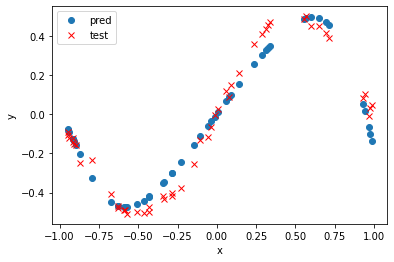

In [48]:
plt.plot(x_test,y_pred,"o",label="pred")
plt.plot(x_test,y_test,"xr",label="test")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
#plt.show()
plt.savefig('fig-depth5.png')

In [49]:
max(y_pred)

array([0.49549553], dtype=float32)

In [50]:
1/np.sqrt(2)

0.7071067811865475